This code produces a plot of the typical duration (in days) of each ITCZ state in IMERG observations and reanalyses.

In [1]:
#Author: Alex Gonzalez
#Date: November 2025
#Paper: JGR-Atmospheres

Figure S2. Inter-quartile range of East Pacific ITCZ state duration (days) for all observations
(IMERG (MW+IR), IMERG MW, GPCP) and reanalyses (ERA5, MERRA-2, JRA-3Q, and
CFSR) during February through April, 1998–2024.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
#from netCDF4 import Dataset
import pandas as pd
#import netCDF4

from cartopy import config

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.ticker as mticker

from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
#data # this is a new comment

In [3]:
# months of interest
mn0 = 2
mnf = 4
mn_str = 'Feb-Apr'#'Jan-May'#Feb-Apr'

# months of interest for eITCZ
mn0_e = 12#1
mnf_e = 5#5

# wide latitudes
lats = -20.
latn = 20.

# longitudes – East Pac
#lonw = -170
#lone = -70
lonw = -135
lone = -90

# longitudes – Atlantic
#lonw = -70
#lone = 30
#lonw = -40
#lone = 5

region_fn = 'EastPac'
#region_fn = 'Atlantic'

region_ti = 'East Pacific'
#region_ti = 'Atlantic'

prct_low = 25
prct_high = 75

In [4]:
# year(s) of interest for all but IMERG
yr0 = 1998
yrf = 2034

yr0_IMERG = 2001
yrf_IMERG = 2024

yr_str = str(yr0)+'-'+str(yrf)
rain_thresh_str = '5.0mm'

In [5]:
dri = '/srv/lss/ERA5_1deg/total_precip/'#obs/'
fn  = 'ERA5_ITCZ_st_daily_'+region_fn+'_abs_thresh_'+rain_thresh_str+'.nc'
data = xr.open_dataset(dri+fn)

In [6]:
data

<xarray.Dataset>
Dimensions:          (time: 16802, lon: 46)
Coordinates:
  * time             (time) datetime64[ns] 1979-01-01T09:00:00 ... 2024-12-31
    quantile         float64 ...
  * lon              (lon) float32 -135.0 -134.0 -133.0 ... -92.0 -91.0 -90.0
Data variables:
    itcz_state       (time) float64 ...
    pr_threshold     (time) float64 ...
    pr_threshold_SH  (time) float64 ...
    pr_threshold_NH  (time) float64 ...
    itcz_state_lon   (time, lon) int64 ...
Attributes:
    long_name:            ERA5 daily ITCZ state
    method:               Algorithm developed for daily averaged precipitatio...
    region:               East Pacific Ocean (90-135W)
    precip_threshold:     90th percentile of regional zonally averaged precip
    longitude_threshold:  58 percent of gridpoints must agree on ITCZ state
    ITCZ state numbers:   1=dITCZ, 2=nITCZ, 3=sITCZ, 4=aITCZ, 5=eITCZ

In [7]:
itcz_state_new_xr_init = data['itcz_state']
itcz_state_new_xr_init

<xarray.DataArray 'itcz_state' (time: 16802)>
[16802 values with dtype=float64]
Coordinates:
  * time      (time) datetime64[ns] 1979-01-01T09:00:00 ... 2024-12-31
    quantile  float64 ...
Attributes:
    long_name:            ERA5 daily ITCZ state
    method:               Algorithm developed for daily averaged precipitatio...
    region:               East Pacific Ocean (90-135W)
    precip_threshold:     90th percentile of regional zonally averaged precip
    longitude_threshold:  58 percent of gridpoints must agree on ITCZ state
    ITCZ state numbers:   1=dITCZ, 2=nITCZ, 3=sITCZ, 4=aITCZ, 5=eITCZ

In [8]:
# set up conditional statements 
cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0) & (itcz_state_new_xr_init.time['time.month'] <= mnf) # season of interest
cond2 = (itcz_state_new_xr_init.time['time.year'] <= yrf) & (itcz_state_new_xr_init.time['time.year'] >= yr0) # season of interest
# now find only the times when MJO amplitude is in season of interest AND exceeds some threshold
nitcz_state_era5 = itcz_state_new_xr_init.where((cond1) & (cond2), drop=True) 

cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0) & (itcz_state_new_xr_init.time['time.month'] <= mnf) # season of interest
cond2 = (itcz_state_new_xr_init.time['time.year'] <= yrf) & (itcz_state_new_xr_init.time['time.year'] >= yr0) # season of interest
itcz_state_era5 = itcz_state_new_xr_init.where((cond1) & (cond2), drop=True) 

#cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0_e) & (itcz_state_new_xr_init.time['time.month'] <= mnf_e) # season of interest
cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0_e) | (itcz_state_new_xr_init.time['time.month'] <= mnf_e) # season of interest
cond2 = (itcz_state_new_xr_init.time['time.year'] <= yrf) & (itcz_state_new_xr_init.time['time.year'] >= yr0) # season of interest
eitcz_state_era5 = itcz_state_new_xr_init.where((cond1) & (cond2), drop=True) 

In [9]:
cond_dITCZ_era5 = (itcz_state_era5 == 1)
cond_nITCZ_era5 = (nitcz_state_era5 == 2)
cond_sITCZ_era5 = (itcz_state_era5 == 3)
cond_aITCZ_era5 = (itcz_state_era5 == 4)
cond_eITCZ_era5 = (eitcz_state_era5 == 5)

In [10]:
def compute_ITCZ_state_duration(itcz_state,cond_ITCZ):
    # subset to only times when ITCZ state is present 
    time_ITCZ = itcz_state['time'].where((cond_ITCZ), drop=True)
    nt_ITCZ = len(time_ITCZ)

    # preiliminary estimate of event duration
    delta_t_ITCZ = time_ITCZ.diff('time')/86400000000000 # converts to days
    
    cc = 1 # time counter
    ee = 1 # event counter
    for tt in range(0,nt_ITCZ-1,1):
        if (delta_t_ITCZ[tt] == 1):
            cc = cc + 1
        else:
            nday_event = cc
            nevent_ITCZ = ee
            ee = ee + 1
            cc = 1
    
    cc = 1 # time counter
    ee = 1 # event counter
    ndays_itcz_state = np.zeros((nevent_ITCZ))
    for tt in range(0,nt_ITCZ-1,1):
        if (delta_t_ITCZ[tt] == 1):
            cc = cc + 1
        else:
            ndays_itcz_state[ee-1] = cc
            ee = ee + 1
            cc = 1

    return ndays_itcz_state

In [11]:
def print_plot(nd_ITCZ,prct_low,prct_high,ITCZ_str):

    lower_bound = np.percentile(nd_ITCZ,prct_low)
    upper_bound = np.percentile(nd_ITCZ,prct_high)

    print(ITCZ_str+' typically lasts between '+str(int(lower_bound))+' and '
          +str(int(upper_bound))+' days.')
    print("---------------------------------------------")

    plt.violinplot(nd_ITCZ,showmeans=False,showmedians=True)

In [12]:
nd_nI_era5 = compute_ITCZ_state_duration(nitcz_state_era5,cond_nITCZ_era5)
nd_sI_era5 = compute_ITCZ_state_duration(itcz_state_era5,cond_sITCZ_era5)
nd_dI_era5 = compute_ITCZ_state_duration(itcz_state_era5,cond_dITCZ_era5)
nd_aI_era5 = compute_ITCZ_state_duration(itcz_state_era5,cond_aITCZ_era5)
nd_eI_era5 = compute_ITCZ_state_duration(eitcz_state_era5,cond_eITCZ_era5)

nITCZ typically lasts between 1 and 5 days.
---------------------------------------------
sITCZ typically lasts between 1 and 2 days.
---------------------------------------------
dITCZ typically lasts between 1 and 2 days.
---------------------------------------------
aITCZ typically lasts between 1 and 2 days.
---------------------------------------------
eITCZ typically lasts between 1 and 2 days.
---------------------------------------------


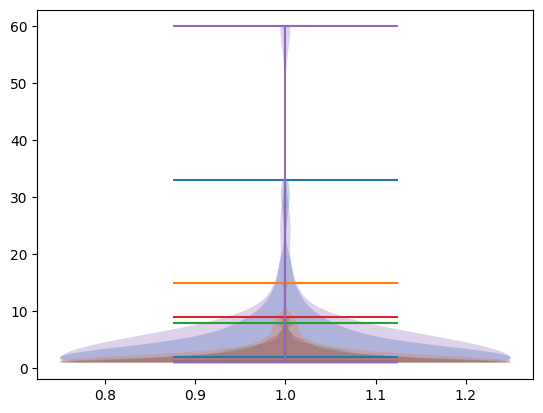

In [13]:
print_plot(nd_nI_era5,prct_low,prct_high,'nITCZ')
print_plot(nd_sI_era5,prct_low,prct_high,'sITCZ')
print_plot(nd_dI_era5,prct_low,prct_high,'dITCZ')
print_plot(nd_aI_era5,prct_low,prct_high,'aITCZ')
print_plot(nd_eI_era5,prct_low,prct_high,'eITCZ')

In [14]:
dri = '/srv/lss/IMERG_1deg/total_precip/'
fn  = 'IMERG_ITCZ_st_daily_'+region_fn+'_abs_thresh_'+rain_thresh_str+'.nc'

data = xr.open_dataset(dri+fn)

itcz_state_new_xr_init = data['itcz_state']#.reset_coords(names=('lat','lon'), drop=True)
itcz_state_new_xr_init

<xarray.DataArray 'itcz_state' (time: 9831)>
[9831 values with dtype=float64]
Coordinates:
  * time      (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2024-11-30
    quantile  float64 ...
Attributes:
    long_name:            IMERG daily ITCZ state
    method:               Algorithm developed for daily averaged precipitatio...
    region:               East Pacific Ocean (90-135W)
    precip_threshold:     90th percentile of regional zonally averaged precip
    longitude_threshold:  58 percent of gridpoints must agree on ITCZ state
    ITCZ state numbers:   1=dITCZ, 2=nITCZ, 3=sITCZ, 4=aITCZ, 5=eITCZ

In [15]:
# set up conditional statements 
cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0) & (itcz_state_new_xr_init.time['time.month'] <= mnf) # season of interest
cond2 = (itcz_state_new_xr_init.time['time.year'] <= yrf) & (itcz_state_new_xr_init.time['time.year'] >= yr0) # season of interest
# now find only the times when MJO amplitude is in season of interest AND exceeds some threshold
nitcz_state_tmpa = itcz_state_new_xr_init.where((cond1) & (cond2), drop=True) 

cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0) & (itcz_state_new_xr_init.time['time.month'] <= mnf) # season of interest
cond2 = (itcz_state_new_xr_init.time['time.year'] <= yrf) & (itcz_state_new_xr_init.time['time.year'] >= yr0) # season of interest
itcz_state_tmpa = itcz_state_new_xr_init.where((cond1) & (cond2), drop=True) 

#cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0_e) & (itcz_state_new_xr_init.time['time.month'] <= mnf_e) # season of interest
cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0_e) | (itcz_state_new_xr_init.time['time.month'] <= mnf_e) # season of interest
cond2 = (itcz_state_new_xr_init.time['time.year'] <= yrf) & (itcz_state_new_xr_init.time['time.year'] >= yr0) # season of interest
eitcz_state_tmpa = itcz_state_new_xr_init.where((cond1) & (cond2), drop=True) 

In [16]:
# now composite average precip for specific ITCZ states
# set up conditional statements 
cond_dITCZ_tmpa = (itcz_state_tmpa == 1)
cond_nITCZ_tmpa = (nitcz_state_tmpa == 2)
cond_sITCZ_tmpa = (itcz_state_tmpa == 3)
cond_aITCZ_tmpa = (itcz_state_tmpa == 4)
cond_eITCZ_tmpa = (eitcz_state_tmpa == 5)

In [17]:
nd_nI_tmpa = compute_ITCZ_state_duration(nitcz_state_tmpa,cond_nITCZ_tmpa)
nd_sI_tmpa = compute_ITCZ_state_duration(itcz_state_tmpa,cond_sITCZ_tmpa)
nd_dI_tmpa = compute_ITCZ_state_duration(itcz_state_tmpa,cond_dITCZ_tmpa)
nd_aI_tmpa = compute_ITCZ_state_duration(itcz_state_tmpa,cond_aITCZ_tmpa)
nd_eI_tmpa = compute_ITCZ_state_duration(eitcz_state_tmpa,cond_eITCZ_tmpa)

nITCZ typically lasts between 1 and 5 days.
---------------------------------------------
sITCZ typically lasts between 1 and 2 days.
---------------------------------------------
dITCZ typically lasts between 1 and 2 days.
---------------------------------------------
aITCZ typically lasts between 1 and 2 days.
---------------------------------------------
eITCZ typically lasts between 1 and 3 days.
---------------------------------------------


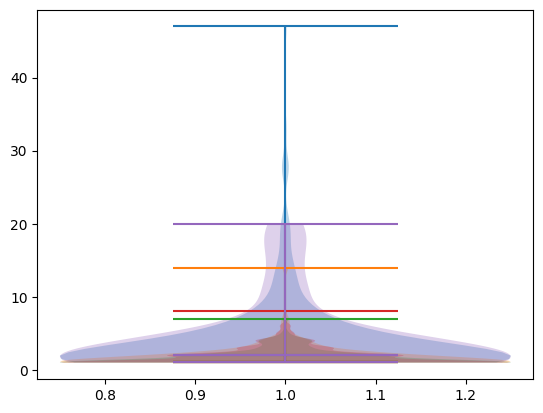

In [18]:
print_plot(nd_nI_tmpa,prct_low,prct_high,'nITCZ')
print_plot(nd_sI_tmpa,prct_low,prct_high,'sITCZ')
print_plot(nd_dI_tmpa,prct_low,prct_high,'dITCZ')
print_plot(nd_aI_tmpa,prct_low,prct_high,'aITCZ')
print_plot(nd_eI_tmpa,prct_low,prct_high,'eITCZ')

In [19]:
dri = '/srv/lss/GPCP_daily/total_precip/'
fn  = 'GPCP_ITCZ_st_daily_'+region_fn+'_abs_thresh_'+rain_thresh_str+'.nc'

data = xr.open_dataset(dri+fn)

itcz_state_new_xr_init = data['itcz_state']#.reset_coords(names=('lat','lon'), drop=True)
itcz_state_new_xr_init

<xarray.DataArray 'itcz_state' (time: 10258)>
[10258 values with dtype=float64]
Coordinates:
  * time      (time) datetime64[ns] 1996-10-01 1996-10-02 ... 2024-10-31
    quantile  float64 ...
Attributes:
    long_name:            GPCP daily ITCZ state
    method:               Algorithm developed for daily averaged precipitatio...
    region:               East Pacific Ocean (90-135W)
    precip_threshold:     90th percentile of regional zonally averaged precip
    longitude_threshold:  58 percent of gridpoints must agree on ITCZ state
    ITCZ state numbers:   1=dITCZ, 2=nITCZ, 3=sITCZ, 4=aITCZ, 5=eITCZ

In [20]:
# set up conditional statements 
cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0) & (itcz_state_new_xr_init.time['time.month'] <= mnf) # season of interest
cond2 = (itcz_state_new_xr_init.time['time.year'] <= yrf) & (itcz_state_new_xr_init.time['time.year'] >= yr0) # season of interest
# now find only the times when MJO amplitude is in season of interest AND exceeds some threshold
nitcz_state_gpcp= itcz_state_new_xr_init.where((cond1) & (cond2), drop=True) 

cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0) & (itcz_state_new_xr_init.time['time.month'] <= mnf) # season of interest
cond2 = (itcz_state_new_xr_init.time['time.year'] <= yrf) & (itcz_state_new_xr_init.time['time.year'] >= yr0) # season of interest
itcz_state_gpcp = itcz_state_new_xr_init.where((cond1) & (cond2), drop=True) 

#cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0_e) & (itcz_state_new_xr_init.time['time.month'] <= mnf_e) # season of interest
cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0_e) | (itcz_state_new_xr_init.time['time.month'] <= mnf_e) # season of interest
cond2 = (itcz_state_new_xr_init.time['time.year'] <= yrf) & (itcz_state_new_xr_init.time['time.year'] >= yr0) # season of interest
eitcz_state_gpcp = itcz_state_new_xr_init.where((cond1) & (cond2), drop=True) 

In [21]:
# now composite average precip for specific ITCZ states
# set up conditional statements 
cond_dITCZ_gpcp = (itcz_state_gpcp == 1)
cond_nITCZ_gpcp = (nitcz_state_gpcp == 2)
cond_sITCZ_gpcp = (itcz_state_gpcp == 3)
cond_aITCZ_gpcp = (itcz_state_gpcp == 4)
cond_eITCZ_gpcp = (eitcz_state_gpcp == 5)

In [22]:
nd_nI_gpcp = compute_ITCZ_state_duration(nitcz_state_gpcp,cond_nITCZ_gpcp)
nd_sI_gpcp = compute_ITCZ_state_duration(itcz_state_gpcp,cond_sITCZ_gpcp)
nd_dI_gpcp = compute_ITCZ_state_duration(itcz_state_gpcp,cond_dITCZ_gpcp)
nd_aI_gpcp = compute_ITCZ_state_duration(itcz_state_gpcp,cond_aITCZ_gpcp)
nd_eI_gpcp = compute_ITCZ_state_duration(eitcz_state_gpcp,cond_eITCZ_gpcp)

nITCZ typically lasts between 1 and 3 days.
---------------------------------------------
sITCZ typically lasts between 1 and 2 days.
---------------------------------------------
dITCZ typically lasts between 1 and 2 days.
---------------------------------------------
aITCZ typically lasts between 1 and 3 days.
---------------------------------------------
eITCZ typically lasts between 1 and 2 days.
---------------------------------------------


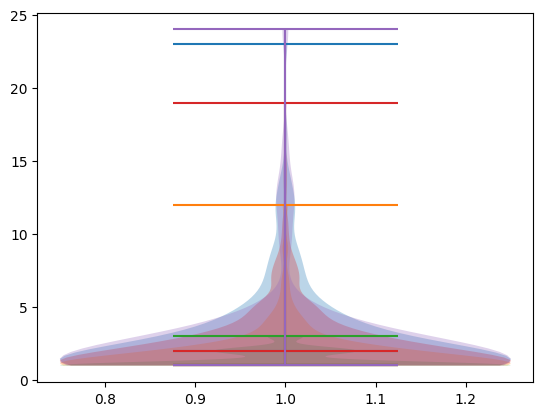

In [23]:
print_plot(nd_nI_gpcp,prct_low,prct_high,'nITCZ')
print_plot(nd_sI_gpcp,prct_low,prct_high,'sITCZ')
print_plot(nd_dI_gpcp,prct_low,prct_high,'dITCZ')
print_plot(nd_aI_gpcp,prct_low,prct_high,'aITCZ')
print_plot(nd_eI_gpcp,prct_low,prct_high,'eITCZ')

In [24]:
dri = '/srv/lss/MERRA-2/total_precip/'
fn  = 'MERRA-2_ITCZ_st_daily_'+region_fn+'_abs_thresh_'+rain_thresh_str+'.nc'
data = xr.open_dataset(dri+fn)

itcz_state_new_xr_init = data['itcz_state']#.reset_coords(names=('lat','lon'), drop=True)
itcz_state_new_xr_init

<xarray.DataArray 'itcz_state' (time: 16528)>
[16528 values with dtype=float64]
Coordinates:
  * time      (time) datetime64[ns] 1980-01-01T12:00:00 ... 2025-04-01T12:00:00
    quantile  float64 ...
Attributes:
    long_name:            MERRA-2 daily ITCZ state
    method:               Algorithm developed for daily averaged precipitatio...
    region:               East Pacific Ocean (90-135W)
    precip_threshold:     90th percentile of regional zonally averaged precip
    longitude_threshold:  58 percent of gridpoints must agree on ITCZ state
    ITCZ state numbers:   1=dITCZ, 2=nITCZ, 3=sITCZ, 4=aITCZ, 5=eITCZ

In [25]:
# set up conditional statements 
cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0) & (itcz_state_new_xr_init.time['time.month'] <= mnf) # season of interest
cond2 = (itcz_state_new_xr_init.time['time.year'] <= yrf) & (itcz_state_new_xr_init.time['time.year'] >= yr0) # season of interest
# now find only the times when MJO amplitude is in season of interest AND exceeds some threshold
nitcz_state_merra = itcz_state_new_xr_init.where((cond1) & (cond2), drop=True) 

cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0) & (itcz_state_new_xr_init.time['time.month'] <= mnf) # season of interest
cond2 = (itcz_state_new_xr_init.time['time.year'] <= yrf) & (itcz_state_new_xr_init.time['time.year'] >= yr0) # season of interest
itcz_state_merra = itcz_state_new_xr_init.where((cond1) & (cond2), drop=True) 

#cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0_e) & (itcz_state_new_xr_init.time['time.month'] <= mnf_e) # season of interest
cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0_e) | (itcz_state_new_xr_init.time['time.month'] <= mnf_e) # season of interest
cond2 = (itcz_state_new_xr_init.time['time.year'] <= yrf) & (itcz_state_new_xr_init.time['time.year'] >= yr0) # season of interest
eitcz_state_merra = itcz_state_new_xr_init.where((cond1) & (cond2), drop=True) 

In [26]:
# now composite average precip for specific ITCZ states
# set up conditional statements 
cond_dITCZ_merra = (itcz_state_merra == 1)
cond_nITCZ_merra = (nitcz_state_merra == 2)
cond_sITCZ_merra = (itcz_state_merra == 3)
cond_aITCZ_merra = (itcz_state_merra == 4)
cond_eITCZ_merra = (eitcz_state_merra == 5)

In [27]:
nd_nI_merra = compute_ITCZ_state_duration(nitcz_state_merra,cond_nITCZ_merra)
nd_sI_merra = compute_ITCZ_state_duration(itcz_state_merra,cond_sITCZ_merra)
nd_dI_merra = compute_ITCZ_state_duration(itcz_state_merra,cond_dITCZ_merra)
nd_aI_merra = compute_ITCZ_state_duration(itcz_state_merra,cond_aITCZ_merra)
nd_eI_merra = compute_ITCZ_state_duration(eitcz_state_merra,cond_eITCZ_merra)

nITCZ typically lasts between 1 and 6 days.
---------------------------------------------
sITCZ typically lasts between 1 and 3 days.
---------------------------------------------
dITCZ typically lasts between 1 and 2 days.
---------------------------------------------
aITCZ typically lasts between 1 and 3 days.
---------------------------------------------
eITCZ typically lasts between 1 and 3 days.
---------------------------------------------


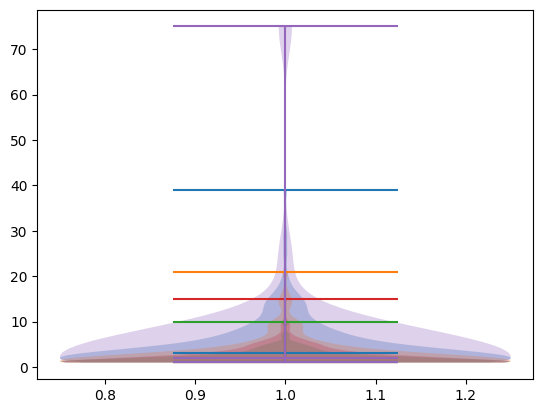

In [28]:
print_plot(nd_nI_merra,prct_low,prct_high,'nITCZ')
print_plot(nd_sI_merra,prct_low,prct_high,'sITCZ')
print_plot(nd_dI_merra,prct_low,prct_high,'dITCZ')
print_plot(nd_aI_merra,prct_low,prct_high,'aITCZ')
print_plot(nd_eI_merra,prct_low,prct_high,'eITCZ')

In [29]:
dri = '/srv/lss/CFSR/total_precip/'
fn  = 'CFSR_ITCZ_st_daily_'+region_fn+'_abs_thresh_'+rain_thresh_str+'.nc'
data = xr.open_dataset(dri+fn)

itcz_state_new_xr_init = data['itcz_state']#.reset_coords(names=('lat','lon'), drop=True)
itcz_state_new_xr_init

<xarray.DataArray 'itcz_state' (time: 16913)>
[16913 values with dtype=float64]
Coordinates:
  * time      (time) datetime64[ns] 1979-01-01T12:00:00 ... 2025-04-21
    quantile  float64 ...
Attributes:
    long_name:            CFSR daily ITCZ state
    method:               Algorithm developed for daily averaged precipitatio...
    region:               East Pacific Ocean (90-135W)
    precip_threshold:     90th percentile of regional zonally averaged precip
    longitude_threshold:  58 percent of gridpoints must agree on ITCZ state
    ITCZ state numbers:   1=dITCZ, 2=nITCZ, 3=sITCZ, 4=aITCZ, 5=eITCZ

In [30]:
# set up conditional statements 
cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0) & (itcz_state_new_xr_init.time['time.month'] <= mnf) # season of interest
cond2 = (itcz_state_new_xr_init.time['time.year'] <= yrf) & (itcz_state_new_xr_init.time['time.year'] >= yr0) # season of interest
# now find only the times when MJO amplitude is in season of interest AND exceeds some threshold
nitcz_state_cfsr = itcz_state_new_xr_init.where((cond1) & (cond2), drop=True) 

cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0) & (itcz_state_new_xr_init.time['time.month'] <= mnf) # season of interest
cond2 = (itcz_state_new_xr_init.time['time.year'] <= yrf) & (itcz_state_new_xr_init.time['time.year'] >= yr0) # season of interest
itcz_state_cfsr = itcz_state_new_xr_init.where((cond1) & (cond2), drop=True) 

#cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0_e) & (itcz_state_new_xr_init.time['time.month'] <= mnf_e) # season of interest
cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0_e) | (itcz_state_new_xr_init.time['time.month'] <= mnf_e) # season of interest
cond2 = (itcz_state_new_xr_init.time['time.year'] <= yrf) & (itcz_state_new_xr_init.time['time.year'] >= yr0) # season of interest
eitcz_state_cfsr = itcz_state_new_xr_init.where((cond1) & (cond2), drop=True) 

In [31]:
# now composite average precip for specific ITCZ states
# set up conditional statements 
cond_dITCZ_cfsr = (itcz_state_cfsr == 1)
cond_nITCZ_cfsr = (nitcz_state_cfsr == 2)
cond_sITCZ_cfsr = (itcz_state_cfsr == 3)
cond_aITCZ_cfsr = (itcz_state_cfsr == 4)
cond_eITCZ_cfsr = (eitcz_state_cfsr == 5)

In [32]:
nd_nI_cfsr = compute_ITCZ_state_duration(nitcz_state_cfsr,cond_nITCZ_cfsr)
nd_sI_cfsr = compute_ITCZ_state_duration(itcz_state_cfsr,cond_sITCZ_cfsr)
nd_dI_cfsr = compute_ITCZ_state_duration(itcz_state_cfsr,cond_dITCZ_cfsr)
nd_aI_cfsr = compute_ITCZ_state_duration(itcz_state_cfsr,cond_aITCZ_cfsr)
nd_eI_cfsr = compute_ITCZ_state_duration(eitcz_state_cfsr,cond_eITCZ_cfsr)

nITCZ typically lasts between 1 and 5 days.
---------------------------------------------
sITCZ typically lasts between 1 and 2 days.
---------------------------------------------
dITCZ typically lasts between 1 and 3 days.
---------------------------------------------
aITCZ typically lasts between 1 and 3 days.
---------------------------------------------
eITCZ typically lasts between 1 and 4 days.
---------------------------------------------


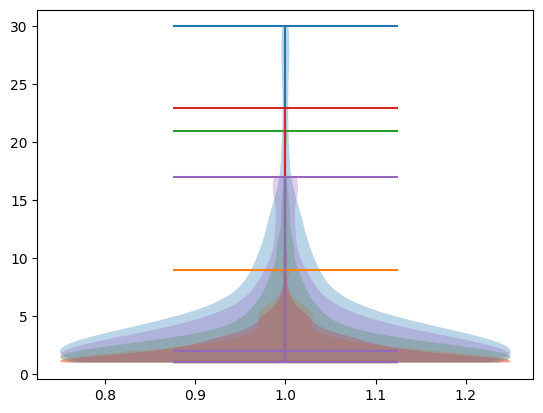

In [33]:
print_plot(nd_nI_cfsr,prct_low,prct_high,'nITCZ')
print_plot(nd_sI_cfsr,prct_low,prct_high,'sITCZ')
print_plot(nd_dI_cfsr,prct_low,prct_high,'dITCZ')
print_plot(nd_aI_cfsr,prct_low,prct_high,'aITCZ')
print_plot(nd_eI_cfsr,prct_low,prct_high,'eITCZ')

In [34]:
dri = '/srv/lss/JRA-3Q/total_precip/'
fn  = 'JRA-3Q_ITCZ_st_daily_'+region_fn+'_abs_thresh_'+rain_thresh_str+'.nc'
data = xr.open_dataset(dri+fn)

itcz_state_new_xr_init = data['itcz_state']#.reset_coords(names=('lat','lon'), drop=True)
itcz_state_new_xr_init

<xarray.DataArray 'itcz_state' (time: 16802)>
[16802 values with dtype=float64]
Coordinates:
  * time      (time) datetime64[ns] 1979-01-01T11:00:00 ... 2024-12-31T11:00:00
    quantile  float64 ...
Attributes:
    long_name:            JRA-3Q daily ITCZ state
    method:               Algorithm developed for daily averaged precipitatio...
    region:               East Pacific Ocean (90-135W)
    precip_threshold:     90th percentile of regional zonally averaged precip
    longitude_threshold:  58 percent of gridpoints must agree on ITCZ state
    ITCZ state numbers:   1=dITCZ, 2=nITCZ, 3=sITCZ, 4=aITCZ, 5=eITCZ

In [35]:
# set up conditional statements 
cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0) & (itcz_state_new_xr_init.time['time.month'] <= mnf) # season of interest
cond2 = (itcz_state_new_xr_init.time['time.year'] <= yrf) & (itcz_state_new_xr_init.time['time.year'] >= yr0) # season of interest
# now find only the times when MJO amplitude is in season of interest AND exceeds some threshold
nitcz_state_jra = itcz_state_new_xr_init.where((cond1) & (cond2), drop=True) 

cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0) & (itcz_state_new_xr_init.time['time.month'] <= mnf) # season of interest
cond2 = (itcz_state_new_xr_init.time['time.year'] <= yrf) & (itcz_state_new_xr_init.time['time.year'] >= yr0) # season of interest
itcz_state_jra = itcz_state_new_xr_init.where((cond1) & (cond2), drop=True) 

#cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0_e) & (itcz_state_new_xr_init.time['time.month'] <= mnf_e) # season of interest
cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0_e) | (itcz_state_new_xr_init.time['time.month'] <= mnf_e) # season of interest
cond2 = (itcz_state_new_xr_init.time['time.year'] <= yrf) & (itcz_state_new_xr_init.time['time.year'] >= yr0) # season of interest
eitcz_state_jra = itcz_state_new_xr_init.where((cond1) & (cond2), drop=True) 

In [36]:
# now composite average precip for specific ITCZ states
# set up conditional statements 
cond_dITCZ_jra = (itcz_state_jra == 1)
cond_nITCZ_jra = (nitcz_state_jra == 2)
cond_sITCZ_jra = (itcz_state_jra == 3)
cond_aITCZ_jra = (itcz_state_jra == 4)
cond_eITCZ_jra = (eitcz_state_jra == 5)

In [37]:
nd_nI_jra = compute_ITCZ_state_duration(nitcz_state_jra,cond_nITCZ_jra)
nd_sI_jra = compute_ITCZ_state_duration(itcz_state_jra,cond_sITCZ_jra)
nd_dI_jra = compute_ITCZ_state_duration(itcz_state_jra,cond_dITCZ_jra)
nd_aI_jra = compute_ITCZ_state_duration(itcz_state_jra,cond_aITCZ_jra)
nd_eI_jra = compute_ITCZ_state_duration(eitcz_state_jra,cond_eITCZ_jra)

nITCZ typically lasts between 1 and 4 days.
---------------------------------------------
sITCZ typically lasts between 1 and 3 days.
---------------------------------------------
dITCZ typically lasts between 1 and 3 days.
---------------------------------------------
aITCZ typically lasts between 1 and 3 days.
---------------------------------------------
eITCZ typically lasts between 1 and 5 days.
---------------------------------------------


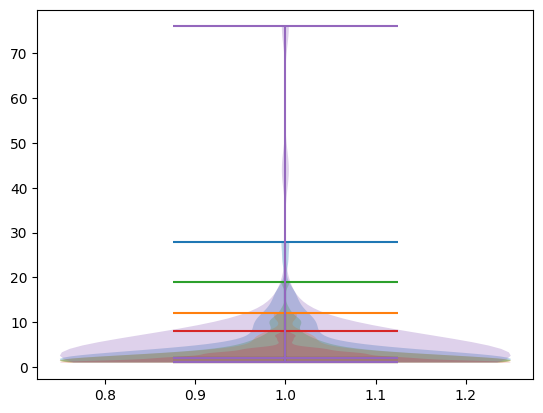

In [38]:
print_plot(nd_nI_jra,prct_low,prct_high,'nITCZ')
print_plot(nd_sI_jra,prct_low,prct_high,'sITCZ')
print_plot(nd_dI_jra,prct_low,prct_high,'dITCZ')
print_plot(nd_aI_jra,prct_low,prct_high,'aITCZ')
print_plot(nd_eI_jra,prct_low,prct_high,'eITCZ')

In [39]:
dri = '/srv/lss/IMERG_1deg/total_precip/'
fn  = 'IMERG_mw_ITCZ_st_daily_'+region_fn+'_abs_thresh_'+rain_thresh_str+'.nc'

data = xr.open_dataset(dri+fn)

itcz_state_new_xr_init = data['itcz_state']#.reset_coords(names=('lat','lon'), drop=True)
itcz_state_new_xr_init

<xarray.DataArray 'itcz_state' (time: 9831)>
[9831 values with dtype=float64]
Coordinates:
  * time      (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2024-11-30
    quantile  float64 ...
Attributes:
    long_name:            IMERG_mw daily ITCZ state
    method:               Algorithm developed for daily averaged precipitatio...
    region:               East Pacific Ocean (90-135W)
    precip_threshold:     90th percentile of regional zonally averaged precip
    longitude_threshold:  58 percent of gridpoints must agree on ITCZ state
    ITCZ state numbers:   1=dITCZ, 2=nITCZ, 3=sITCZ, 4=aITCZ, 5=eITCZ

In [40]:
# set up conditional statements 
cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0) & (itcz_state_new_xr_init.time['time.month'] <= mnf) # season of interest
cond2 = (itcz_state_new_xr_init.time['time.year'] <= yrf_IMERG) & (itcz_state_new_xr_init.time['time.year'] >= yr0_IMERG) # season of interest
# now find only the times when MJO amplitude is in season of interest AND exceeds some threshold
nitcz_state_imerg = itcz_state_new_xr_init.where((cond1) & (cond2), drop=True) 

cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0) & (itcz_state_new_xr_init.time['time.month'] <= mnf) # season of interest
cond2 = (itcz_state_new_xr_init.time['time.year'] <= yrf_IMERG) & (itcz_state_new_xr_init.time['time.year'] >= yr0_IMERG) # season of interest
itcz_state_imerg = itcz_state_new_xr_init.where((cond1) & (cond2), drop=True) 

#cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0_e) & (itcz_state_new_xr_init.time['time.month'] <= mnf_e) # season of interest
cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0_e) | (itcz_state_new_xr_init.time['time.month'] <= mnf_e) # season of interest
cond2 = (itcz_state_new_xr_init.time['time.year'] <= yrf_IMERG) & (itcz_state_new_xr_init.time['time.year'] >= yr0_IMERG) # season of interest
eitcz_state_imerg = itcz_state_new_xr_init.where((cond1) & (cond2), drop=True) 

In [41]:
# now composite average precip for specific ITCZ states
# set up conditional statements 
cond_dITCZ_imerg = (itcz_state_imerg == 1)
cond_nITCZ_imerg = (nitcz_state_imerg == 2)
cond_sITCZ_imerg = (itcz_state_imerg == 3)
cond_aITCZ_imerg = (itcz_state_imerg == 4)
cond_eITCZ_imerg = (eitcz_state_imerg == 5)

In [42]:
nd_nI_imerg = compute_ITCZ_state_duration(nitcz_state_imerg,cond_nITCZ_imerg)
nd_sI_imerg = compute_ITCZ_state_duration(itcz_state_imerg,cond_sITCZ_imerg)
nd_dI_imerg = compute_ITCZ_state_duration(itcz_state_imerg,cond_dITCZ_imerg)
nd_aI_imerg = compute_ITCZ_state_duration(itcz_state_imerg,cond_aITCZ_imerg)
nd_eI_imerg = compute_ITCZ_state_duration(eitcz_state_imerg,cond_eITCZ_imerg)

nITCZ typically lasts between 1 and 5 days.
---------------------------------------------
sITCZ typically lasts between 1 and 2 days.
---------------------------------------------
dITCZ typically lasts between 1 and 2 days.
---------------------------------------------
aITCZ typically lasts between 1 and 2 days.
---------------------------------------------
eITCZ typically lasts between 1 and 1 days.
---------------------------------------------


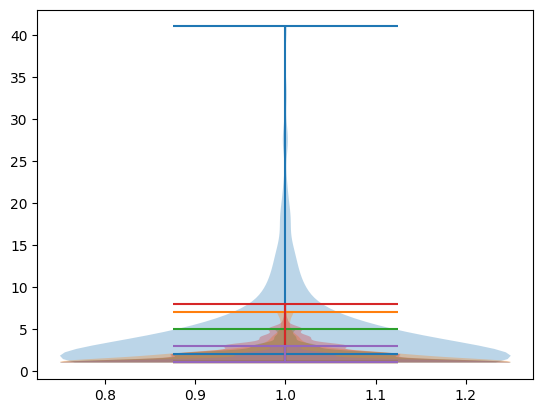

In [43]:
print_plot(nd_nI_imerg,prct_low,prct_high,'nITCZ')
print_plot(nd_sI_imerg,prct_low,prct_high,'sITCZ')
print_plot(nd_dI_imerg,prct_low,prct_high,'dITCZ')
print_plot(nd_aI_imerg,prct_low,prct_high,'aITCZ')
print_plot(nd_eI_imerg,prct_low,prct_high,'eITCZ')

In [44]:
dataset_reana = ['IMERG (MW+IR)','IMERG (MW)','GPCP','ERA5','MERRA-2','JRA-3Q','CFSR']
ndataset_reana = len(dataset_reana)
dataset_reana_xr = xr.DataArray(dataset_reana, coords=[dataset_reana], dims=['dataset'])

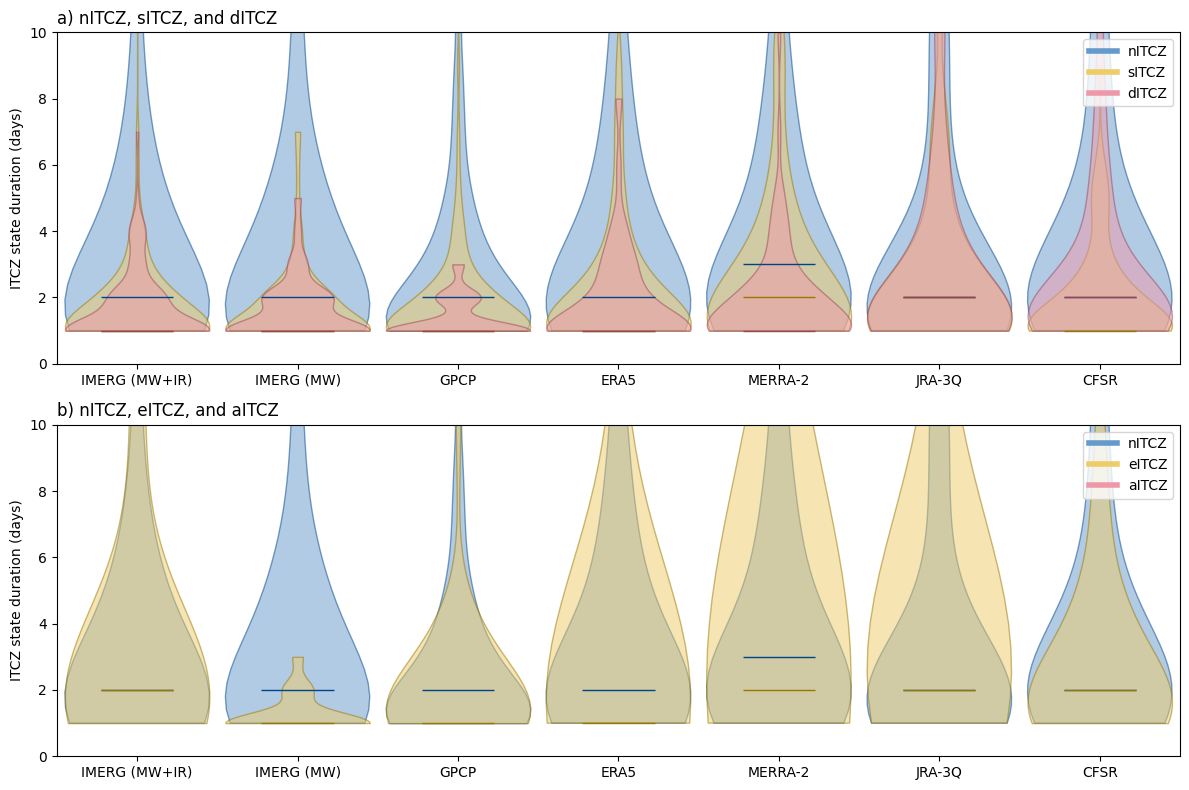

In [45]:
# plot violin plot
npan = 2
from matplotlib.lines import Line2D

# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(12, 8), tight_layout='true')
#fig.suptitle(r'Precipitation threshold distribution for '+region_ti+' Ocean ITCZ states ('+mn_str+', '+yr_str+')',fontsize='xx-large')
for jj in range(0,npan,1):
    ax = fig.add_subplot(2,1,jj+1)
    if jj == 0:
        ax1 = ax.violinplot([nd_nI_tmpa,nd_nI_imerg,nd_nI_gpcp,nd_nI_era5,nd_nI_merra,nd_nI_jra,nd_nI_cfsr],
                          showmeans=False,showmedians=True,showextrema=False,widths=0.9)
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
            vp.set_facecolor('#6699CC')
            vp.set_edgecolor('#004488')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1) 
        ax1 = ax.violinplot([nd_sI_tmpa,nd_sI_imerg,nd_sI_gpcp,nd_sI_era5,nd_sI_merra,nd_sI_jra,nd_sI_cfsr],
                          showmeans=False,showmedians=True,showextrema=False,widths=0.9)

        for vp in ax1['bodies']:
            vp.set_facecolor('#EECC66')
            vp.set_edgecolor('#997700')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#997700')
        vp.set_linewidth(1) 
        
        ax1 = ax.violinplot([nd_dI_tmpa,nd_dI_imerg,nd_dI_gpcp,nd_dI_era5,nd_dI_merra,nd_dI_jra,nd_dI_cfsr],
                          showmeans=False,showmedians=True,showextrema=False,widths=0.9)

        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
            vp.set_facecolor('#EE99AA')
            vp.set_edgecolor('#994455')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#994455')
        vp.set_linewidth(1)
            
        ax.set_title('a) nITCZ, sITCZ, and dITCZ', loc='left')

        custom_lines = [Line2D([0], [0], color='#6699CC', lw=4),
                Line2D([0], [0], color='#EECC66', lw=4),
                Line2D([0], [0], color='#EE99AA', lw=4)]

        ax.legend(custom_lines, ['nITCZ', 'sITCZ', 'dITCZ'])
        plt.ylim(0,10)

    if jj == 1:
        ax1 = ax.violinplot([nd_nI_tmpa,nd_nI_imerg,nd_nI_gpcp,nd_nI_era5,nd_nI_merra,nd_nI_jra,nd_nI_cfsr],
                          showmeans=False,showmedians=True,showextrema=False,widths=0.9)
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
            vp.set_facecolor('#6699CC')
            vp.set_edgecolor('#004488')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1) 
        ax1 = ax.violinplot([nd_eI_tmpa,nd_eI_imerg,nd_eI_gpcp,nd_eI_era5,nd_eI_merra,nd_eI_jra,nd_eI_cfsr],
                          showmeans=False,showmedians=True,showextrema=False,widths=0.9)

        for vp in ax1['bodies']:
            vp.set_facecolor('#EECC66')
            vp.set_edgecolor('#997700')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#997700')
        vp.set_linewidth(1) 
        
        ax1 = ax.violinplot([nd_aI_tmpa*-999,nd_aI_imerg*-999,nd_aI_gpcp*-999,nd_aI_era5*-999,nd_aI_merra*-999,nd_aI_jra*-999,nd_aI_cfsr*-999],
                          showmeans=False,showmedians=True,showextrema=False,widths=0.9)

        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
            vp.set_facecolor('#EE99AA')
            vp.set_edgecolor('#994455')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#994455')
        vp.set_linewidth(1)
            
        ax.set_title('b) nITCZ, eITCZ, and aITCZ', loc='left')

        custom_lines = [Line2D([0], [0], color='#6699CC', lw=4),
                Line2D([0], [0], color='#EECC66', lw=4),
                Line2D([0], [0], color='#EE99AA', lw=4)]

        ax.legend(custom_lines, ['nITCZ', 'eITCZ', 'aITCZ'])
        plt.ylim(0,10)
        
    ax.set_xticks(np.arange(1,8,1), labels=dataset_reana)
    plt.xlim(0.5,7.5)
    #ax.set_xticks(np.arange(1,7,1), labels=dataset)

    plt.ylabel('ITCZ state duration (days)')
figfolder = '/home/alex.gonzalez/CMIP6_ITCZ_state_project/figures/methods_paper/'
#plt.savefig(figfolder+'ITCZ_state_EastPac_obs_precip_thresh_single_vs_double_FMA.pdf',bbox_inches="tight",transparent=False,dpi=150)

In [46]:
# now try histograms 
# column 1: nITCZ
# column 2: sITCZ
# etc.

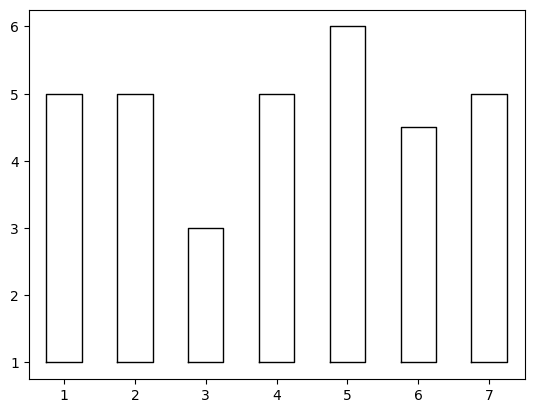

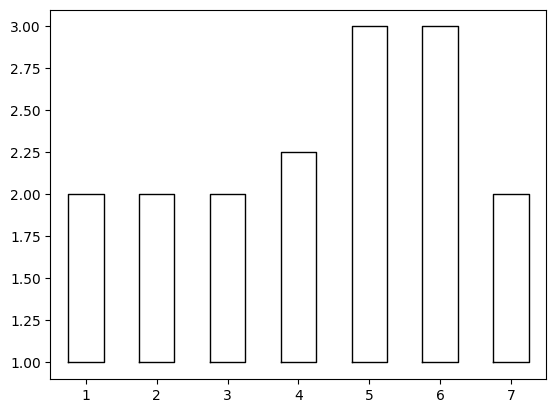

In [47]:
b1 = plt.boxplot([nd_nI_tmpa,nd_nI_imerg,nd_nI_gpcp,nd_nI_era5,nd_nI_merra,nd_nI_jra,nd_nI_cfsr], whis=0, showfliers=False, showcaps=False, medianprops={'linewidth': 0})
plt.show()
b2 = plt.boxplot([nd_sI_tmpa,nd_sI_imerg,nd_sI_gpcp,nd_sI_era5,nd_sI_merra,nd_sI_jra,nd_sI_cfsr], whis=0, showfliers=False, showcaps=False, medianprops={'linewidth': 0})
plt.show()

In [48]:

#cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0_e) & (itcz_state_new_xr_init.time['time.month'] <= mnf_e) # season of interest
cond1 = (itcz_state_new_xr_init.time['time.month'] >= mn0_e) | (itcz_state_new_xr_init.time['time.month'] <= mnf_e) # season of interest

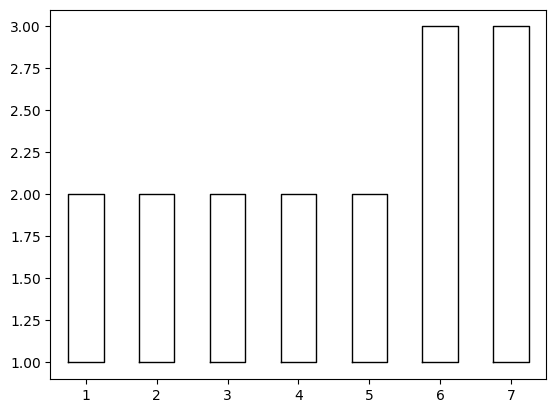

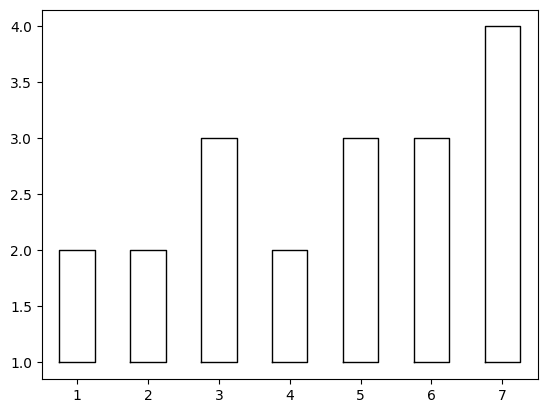

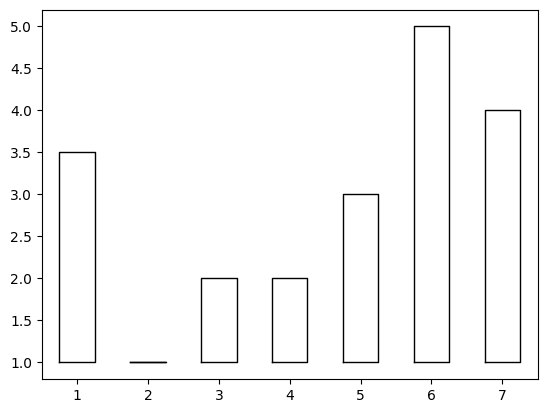

In [49]:
b3 = plt.boxplot([nd_dI_tmpa,nd_dI_imerg,nd_dI_gpcp,nd_dI_era5,nd_dI_merra,nd_dI_jra,nd_dI_cfsr], whis=0, showfliers=False, showcaps=False, medianprops={'linewidth': 0})
plt.show()

b4 = plt.boxplot([nd_aI_tmpa,nd_aI_imerg,nd_aI_gpcp,nd_aI_era5,nd_aI_merra,nd_aI_jra,nd_eI_cfsr], whis=0, showfliers=False, showcaps=False, medianprops={'linewidth': 0})
plt.show()

b5 = plt.boxplot([nd_eI_tmpa,nd_eI_imerg,nd_eI_gpcp,nd_eI_era5,nd_eI_merra,nd_eI_jra,nd_eI_cfsr], whis=0, showfliers=False, showcaps=False, medianprops={'linewidth': 0})
plt.show()

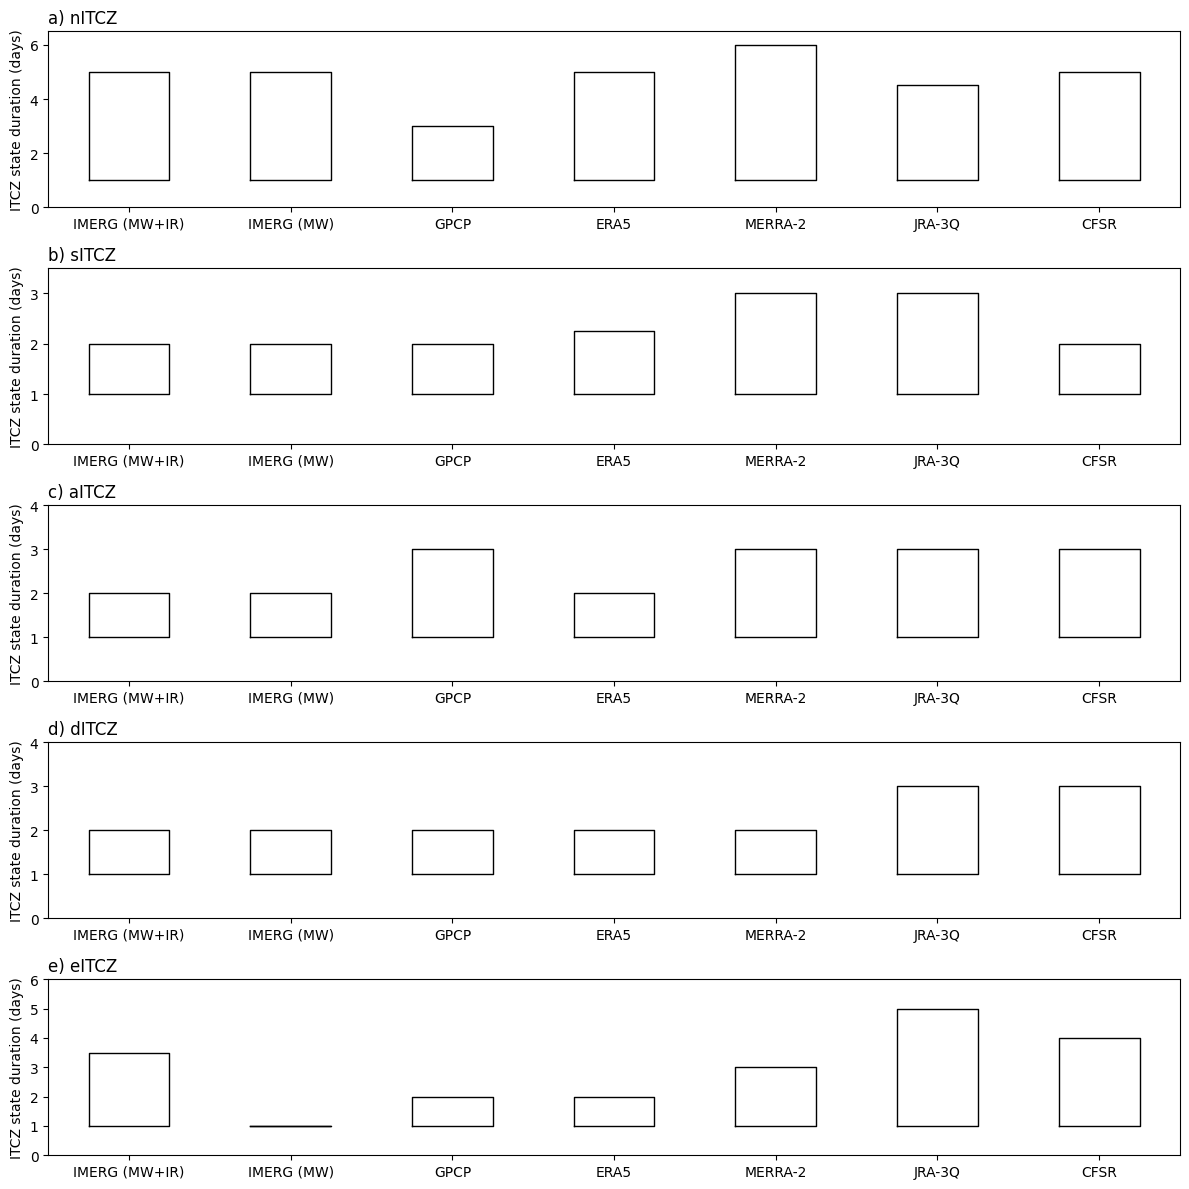

In [56]:
# plot violin plot
npan = 5

from matplotlib.lines import Line2D

# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(12, 12), tight_layout='true')
#fig.suptitle(r'Precipitation threshold distribution for '+region_ti+' Ocean ITCZ states ('+mn_str+', '+yr_str+')',fontsize='xx-large')
for jj in range(0,npan,1):
    ax = fig.add_subplot(npan,1,jj+1)
    if jj == 0:
        ax1 = ax.boxplot([nd_nI_tmpa,nd_nI_imerg,nd_nI_gpcp,nd_nI_era5,nd_nI_merra,nd_nI_jra,nd_nI_cfsr], \
                          whis=0, showfliers=False, showcaps=False, medianprops={'linewidth': 0})
        ax.set_title('a) nITCZ', loc='left')
        plt.ylim(0,6.5)

    if jj == 1:
        ax1 = ax.boxplot([nd_sI_tmpa,nd_sI_imerg,nd_sI_gpcp,nd_sI_era5,nd_sI_merra,nd_sI_jra,nd_sI_cfsr], \
                          whis=0, showfliers=False, showcaps=False, medianprops={'linewidth': 0})
        ax.set_title('b) sITCZ', loc='left')   
        plt.ylim(0,3.5)

    if jj == 2:
        ax1 = ax.boxplot([nd_aI_tmpa,nd_aI_imerg,nd_aI_gpcp,nd_aI_era5,nd_aI_merra,nd_aI_jra,nd_aI_cfsr], \
                          whis=0, showfliers=False, showcaps=False, medianprops={'linewidth': 0})
        ax.set_title('c) aITCZ', loc='left') 

    if jj == 3:
        ax1 = ax.boxplot([nd_dI_tmpa,nd_dI_imerg,nd_dI_gpcp,nd_dI_era5,nd_dI_merra,nd_dI_jra,nd_dI_cfsr], \
                          whis=0, showfliers=False, showcaps=False, medianprops={'linewidth': 0})
        ax.set_title('d) dITCZ', loc='left')  
        
    if jj == 4:
        ax1 = ax.boxplot([nd_eI_tmpa,nd_eI_imerg,nd_eI_gpcp,nd_eI_era5,nd_eI_merra,nd_eI_jra,nd_eI_cfsr], \
                          whis=0, showfliers=False, showcaps=False, medianprops={'linewidth': 0})
        ax.set_title('e) eITCZ', loc='left') 
    
    if jj > 1:
        plt.ylim(0,4)

    if jj == 4:
        plt.ylim(0,6)
        
    ax.set_xticks(np.arange(1,8,1), labels=dataset_reana)
    plt.xlim(0.5,7.5)
    #ax.set_xticks(np.arange(1,7,1), labels=dataset)

    plt.ylabel('ITCZ state duration (days)')
figfolder = '/home/alex.gonzalez/CMIP6_ITCZ_state_project/figures/methods_paper/revision/'
plt.savefig(figfolder+'ITCZ_state_EastPac_obs_reana_duration.pdf',bbox_inches="tight",transparent=False,dpi=150)